INFO:
- sequences
    - yeast:
    - human:
- file size:
    - xml: yeast_query.xml = 842 MB, human_query.xml = 3.34 GB
    - tsv: yeast = 73 MB, human = 334.9 MB (10-fold reduction)
- data
    - yeast
        - hits: 395851
    - human
        - hits: 1728526

In [1]:
# tools
import time
import csv
import pandas as pd
from Bio.Blast import NCBIXML
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

import dask.dataframe as dd
from Bio import Entrez, SeqIO
from Bio.Blast import NCBIWWW, NCBIXML

In [3]:
# parse blast data (takes time)
with open('yeast_query.xml') as result_handle, open('yeast_query.tsv', 'w', newline='') as csvout:
    writer = csv.writer(csvout, delimiter='\t')
    for blast_result in NCBIXML.parse(result_handle):
        q = blast_result.query
        for desc in blast_result.descriptions:
            hit = desc.title
            e = desc.e
            score = desc.score
            writer.writerow([q, hit, e, score, 'yeast'])

# get human query data
with open('human_query.xml') as result_handle, open('human_query.tsv', 'w', newline='') as csvout:
    writer = csv.writer(csvout, delimiter='\t')
    for blast_result in NCBIXML.parse(result_handle):
        q = blast_result.query
        for desc in blast_result.descriptions:
            hit = desc.title
            e = desc.e
            score = desc.score
            writer.writerow([q, hit, e, score, 'human'])

In [ ]:
# organize the parsed files
files = ['yeast_query.tsv','human_query.tsv']

dfs = [pd.read_csv(f, sep='\t', names=['query','hit','evalue', 'score', 'organism']) for f in files]

df = pd.concat(dfs)

df['q_desc'] = df['query'].str.split('[').str[0].str.split(' ', 1).str[1]
df['organism'] = df['query'].str.rsplit("[",1).str[1].str[:-1]
df['query'] = df['query'].str.split(' ').str[0]
df['h_desc'] = df['hit'].str.split('[').str[0].str.split(' ',2).str[2]
df['hit'] = df['hit'].str.split(' ').str[1]

mins_df=pd.DataFrame(df.groupby('query')['evalue'].min())
mins_df['min']=True
final_output=df.merge(mins_df, how='left', left_on=['query','evalue'], right_on=['query','evalue'])
final_output.fillna(False, inplace=True)

df = df.sort_values(by=['organism','query','evalue'])
df.reset_index(drop=True, inplace=True)

df.to_csv('data.csv', index=False)

In [1]:
df.shape

NameError: name 'df' is not defined

In [ ]:
# test query
# true case
a = 'NP_006436.3'
b = 'NP_012035.1'

c = final_output.lo`a
c[(final_output['query'] == a) & (final_output['hit'] == b), 'min']
d = final_output.loc[(final_output['query'] == b) & (final_output['hit'] == c), 'min']
c.bool() == c.bool()

In [ ]:
# false case
a = 'NP_006436.3'
b = 'NP_013267.1'

c = final_output.loc[(final_output['query'] == a) & (final_output['hit'] == b), 'min']
d = final_output.loc[(final_output['query'] == b) & (final_output['hit'] == a), 'min']
c.bool() == d.bool()

In [5]:
# yeast
df_yeast = pd.read_csv('yeast_query.tsv', sep='\t', names=['query','hit','evalue', 'score', 'organism'])
df_yeast['q_desc'] = df_yeast['query'].str.split('[').str[0].str.split(' ', 1).str[1]
df_yeast['query'] = df_yeast['query'].str.split(' ').str[0]
df_yeast['h_desc'] = df_yeast['hit'].str.split('[').str[0].str.split(' ',2).str[2]
df_yeast['hit'] = df_yeast['hit'].str.split(' ').str[1]

In [6]:
df_human = pd.read_csv('human_query.tsv', sep='\t', names=['query','hit','evalue', 'score', 'organism'])
df_human['q_desc'] = df_human['query'].str.split('[').str[0].str.split(' ', 1).str[1]
df_human['query'] = df_human['query'].str.split(' ').str[0]
df_human['h_desc'] = df_human['hit'].str.split('[').str[0].str.split(' ',2).str[2]
df_human['hit'] = df_human['hit'].str.split(' ').str[1]

In [ ]:
df_yeast.to_csv('yeast.csv', index=False)
df_human.to_csv('human.csv', index=False)

In [7]:
# combine
df = pd.concat([df_yeast, df_human])

In [70]:
# create 'min' column

# save the minimums as a dataframe, and set value of new-variable 'minimum' to True
mins_df=pd.DataFrame(df.groupby('query')['evalue'].min())
mins_df['min']=True

#left join the minimums_df onto the original df.
df=df.merge(mins_df, how='left', left_on=['query','evalue'], right_on=['query','evalue'])

#replace the NaN with False, i.e. those that were not in mins_df
df.fillna(False, inplace=True)

df.to_csv('data.csv', index=False)

In [69]:
df.shape

(2124377, 7)

In [ ]:
# should now have everything saved
# currently trying to get boolean columns for is minimum
# then need a function to scan just the minimums and put them aside (maybe with index method?)
# no method for finding mutual lowpoint

In [10]:
df_yeast = pd.read_csv('yeast.csv')
df_yeast.shape

(395851, 7)

In [2]:
df = pd.read_csv('data.csv')
df.shape

(2124377, 7)

In [4]:
df.index

RangeIndex(start=0, stop=2124377, step=1)

In [9]:
df['organism'].value_counts()

human    1728526
yeast     395851
Name: organism, dtype: int64

In [11]:
# try tom's solution
ts1=time.time()

# save the minimums as a dataframe, and set value of new-variable 'minimum' to True
mins_df=pd.DataFrame(df.groupby('query')['evalue'].min())
mins_df['min']=True

#left join the minimums_df onto the original df.
final_output=df.merge(mins_df, how='left', left_on=['query','evalue'], right_on=['query','evalue'])

#replace the NaN with False, i.e. those that were not in mins_df
final_output.fillna(False, inplace=True)

print(time.time() - ts1, " seconds elapsed")

In [21]:
cross_df = pd.DataFrame(pd.crosstab(final_output['query'], final_output['min'], dropna=False))

min             False  True 
query                       
NP_000005.3         6      1
NP_000006.2         4      1
NP_000007.1         4      1
NP_000008.1         3      1
NP_000009.1         4      1
...               ...    ...
YP_003024033.1      2      1
YP_003024035.1      7      1
YP_003024036.1      0      1
YP_003024037.1      2      1
YP_003024038.1      5      1

[117768 rows x 2 columns]

In [40]:
# true case
a = 'NP_006436.3'
b = 'NP_012035.1'

c = final_output.loc[(final_output['query'] == a) & (final_output['hit'] == b), 'min']
d = final_output.loc[(final_output['query'] == b) & (final_output['hit'] == c), 'min']
c.bool() == c.bool()

1030738    True
Name: min, dtype: bool

In [52]:
# false case
a = 'NP_006436.3'
b = 'NP_013267.1'

c = final_output.loc[(final_output['query'] == a) & (final_output['hit'] == b), 'min']
d = final_output.loc[(final_output['query'] == b) & (final_output['hit'] == a), 'min']
c.bool() == d.bool()

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [55]:
final_output.loc[(final_output['query'] == b) & (final_output['hit'] == a)]

Empty DataFrame
Columns: [query, hit, evalue, score, organism, q_desc, h_desc, min]
Index: []

In [60]:
a = 'NP_006436.3'
b = 'NP_013267.1'
if ((final_output['query'] == a) & (df['hit'] == b)).any():
    c = final_output.loc[(final_output['query'] == a) & (final_output['hit'] == b), 'min'].bool()
# reverse
if ((final_output['query'] == b) & (df['hit'] == a)).any():
    d = final_output.loc[(final_output['query'] == b) & (final_output['hit'] == a), 'min'].bool()
c == d

Series([], Name: min, dtype: bool)

In [65]:
# false case
a = 'NP_001018030.1'
b = 'XP_011536148.1'
c = final_output.loc[(final_output['query'] == a) & (final_output['hit'] == b), 'min'].bool()
d = final_output.loc[(final_output['query'] == b) & (final_output['hit'] == a), 'min'].bool()

In [66]:
c == d

False

In [64]:
final_output.loc[(final_output['query'] == b) & (final_output['hit'] == a)]

query             hit        evalue  score organism  \
1608952  XP_011536148.1  NP_001018030.1  1.443400e-57  477.0    human   

                                      q_desc  \
1608952  serine dehydratase-like isoform X2    

                                           h_desc   min  
1608952  L-serine/L-threonine ammonia-lyase CHA1   True

In [29]:
final_output.head()

query             hit        evalue  score organism  \
0  NP_001018030.1     NP_006834.2  6.047210e-40  367.0    yeast   
1  NP_001018030.1  XP_011536148.1  2.964610e-37  348.0    yeast   
2  NP_001018030.1  XP_005253888.1  2.964610e-37  348.0    yeast   
3  NP_001018030.1     NP_612441.1  2.964610e-37  348.0    yeast   
4  NP_001018030.1  NP_001291922.1  2.964610e-37  348.0    yeast   

                                     q_desc  \
0  L-serine/L-threonine ammonia-lyase CHA1    
1  L-serine/L-threonine ammonia-lyase CHA1    
2  L-serine/L-threonine ammonia-lyase CHA1    
3  L-serine/L-threonine ammonia-lyase CHA1    
4  L-serine/L-threonine ammonia-lyase CHA1    

                                        h_desc    min  
0  L-serine dehydratase/L-threonine deaminase    True  
1          serine dehydratase-like isoform X2   False  
2          serine dehydratase-like isoform X2   False  
3                     serine dehydratase-like   False  
4                     serine dehydratase-like   False

In [18]:
mins_df['evalue'].max()

9.99698

In [169]:
df['query'].nunique()

117768

In [10]:
new_df = dd.from_pandas(df, 24)

In [11]:
# sort: organism, query, evalue
# reindex
df = df.sort_values(by=['organism','query','evalue'])

df.reset_index(drop=True, inplace=True)

In [12]:
# need a minimum column, bool
def is_min(row):
    # get the minimum quantity for the given category value
    cat_min = df[df['query'] == row['query']]['evalue'].min()
    # get the minimum quantity for the current row
    row_min = row['evalue']
    return cat_min == row_min

new_df['is_min'] = new_df.apply(lambda x: is_min(x), axis=1, meta='bool')

In [ ]:
pand_df = new_df.compute()

In [ ]:
df['is_min'] = df.apply(lambda x: is_min(x), axis=1)

In [ ]:
pand_df.to_csv('pand_df.csv', index=False)

In [ ]:
df.to_csv('is_min.csv', index=False)

In [ ]:
df.apply(lambda x: check_min(x), axis=1)

In [ ]:
df.groupby('query')['evalue'].idxmin(axis=0)

In [163]:
df[df['organism'] == 'yeast']['query'].nunique()

5356

In [164]:
df[df['organism'] == 'human']['query'].nunique()

112412

In [146]:
# function to find reciprocal matches
# ans: NP_006436.3 -> NP_012035.1

# trick is to just search the minimals
# create new dataframe
df.groupby('query')['evalue'].min()

query
NP_000005.3        1.178900e+00
NP_000006.2        6.899470e-01
NP_000007.1        4.345580e-03
NP_000008.1        3.661760e-10
NP_000009.1        3.588200e-02
                      ...      
YP_003024033.1     1.837480e+00
YP_003024035.1     1.461130e-01
YP_003024036.1     3.288700e+00
YP_003024037.1     1.725600e-01
YP_003024038.1    1.446920e-129
Name: evalue, Length: 117768, dtype: float64

In [154]:
df.loc[(df['query'] == 'NP_006436.3') & (df['hit'] == 'NP_012035.1')]

query          hit  evalue   score organism  \
634887  NP_006436.3  NP_012035.1     0.0  7931.0    human   

                                        q_desc  \
634887  pre-mRNA-processing-splicing factor 8    

                                      h_desc  
634887  U4/U6-U5 snRNP complex subunit PRP8

In [134]:
df.groupby['query']['evalue'].min()

TypeError: 'method' object is not subscriptable

In [ ]:
['NP_006436.3','NP_012035.1','NP_013267.1','NP_013374.1']

In [113]:
df[(df['query'] == 'NP_006436.3') | (df['hit'] == 'NP_006436.3')]

query          hit   evalue   score organism  \
172550  NP_012035.1  NP_006436.3  0.00000  7871.0    yeast   
634887  NP_006436.3  NP_012035.1  0.00000  7931.0    human   
634888  NP_006436.3  NP_013267.1  6.01830    66.0    human   
634889  NP_006436.3  NP_013374.1  6.37307    65.0    human   

                                        q_desc  \
172550    U4/U6-U5 snRNP complex subunit PRP8    
634887  pre-mRNA-processing-splicing factor 8    
634888  pre-mRNA-processing-splicing factor 8    
634889  pre-mRNA-processing-splicing factor 8    

                                        h_desc  
172550  pre-mRNA-processing-splicing factor 8   
634887    U4/U6-U5 snRNP complex subunit PRP8   
634888                  exocyst subunit SEC10   
634889                 condensin subunit YCS4

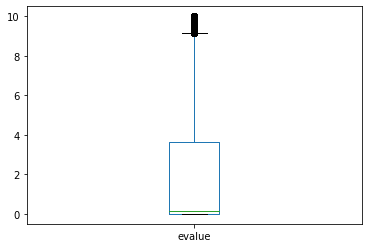

In [20]:
# reciprocal blast alignment


In [22]:
# combine
df1 = pd.read_csv('yeast_query.tsv', sep='\t', names=['query','hit','evalue', 'score', 'organism'])
df2 = pd.read_csv('human_query.tsv', sep='\t', names=['query','hit','evalue', 'score', 'organism'])
df = pd.concat([df1, df2])

In [23]:
df.shape

(2124377, 5)

In [24]:
1728526 + 395851

2124377